# Reconhecimento de Padrões (TIP8311) - Trabalho 3


**Professor:** Guilherme de Alencar Barreto  

<img src="https://loop.frontiersin.org/images/profile/243428/203" alt="Foto do Professor" width="150"/>


**Aluno:** Luis Felipe Carneiro de Souza    **Matrícula:** 593430

Importação de bibliotecas

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

Caminho para salvar gráficos

In [56]:
BASE = Path('..').resolve()
graficos = BASE / "trabalho-3" / "graficos"

Caminho do conjunto de dados

In [14]:
data_path = "wall+following+robot+navigation+data/sensor_readings_24.data"

Funções utilizadas

In [15]:
class CQG:
    def __init__(self, reg=1e-8):
        self.reg = float(reg)
        self.classes_ = None
        self.means_ = {}
        self.priors_ = {}
        self.inv_covs_ = {}
        self.logdets_ = {}

    def _mcov(self, X_i):
        """
        Calcula a matriz de covariância manualmente.
        X_i: shape (p, N) -> p = nº features, N = nº amostras
        """
        p, N = X_i.shape
        m = X_i.mean(axis=1).reshape(-1, 1)
        R = (X_i @ X_i.T) / N
        C = R - (m @ m.T)
        return C

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y).ravel()
        
        self.classes_ = np.sort(np.unique(y))
        n_samples = X.shape[0]

        for c in self.classes_:
            Xc = X[y == c]
            Nc = len(Xc)

            # 1. Priori e Médias (média armazenada como 1D para o predict vetorizado)
            self.priors_[c] = Nc / n_samples
            self.means_[c] = Xc.mean(axis=0)

            # 2. Covariância usando o seu método manual (passando Xc transposto)
            cov_c = self._mcov(Xc.T)
            
            # 3. Regularização para estabilidade numérica
            cov_c += self.reg * np.eye(cov_c.shape[0])

            # 4. Pré-computar inversa e log-determinante no momento do TREINO
            sign, logdet = np.linalg.slogdet(cov_c)
            self.logdets_[c] = logdet
            self.inv_covs_[c] = np.linalg.inv(cov_c)

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        n_samples = X.shape[0]
        
        # Matriz para armazenar o score g_i(x) de cada amostra para cada classe
        scores = np.zeros((n_samples, len(self.classes_)))

        for idx, c in enumerate(self.classes_):
            # Diferença vetorizada: amostras - média da classe C
            diff = X - self.means_[c] 
            
            # Cálculo vetorizado de Q_i(x) = (x - m)^T C^{-1} (x - m)
            Qi = np.sum((diff @ self.inv_covs_[c]) * diff, axis=1)
            
            # Função discriminante: g*_i(x) = Q_i(x) + ln(|C_i|) - 2 ln(P(w_i))
            scores[:, idx] = Qi + self.logdets_[c] - 2.0 * np.log(self.priors_[c])

        # A classe predita é a que possui o MENOR score g_i(x)
        best_class_idx = np.argmin(scores, axis=1)
        return self.classes_[best_class_idx]

In [16]:
class Kmeans:
    def __init__(self, k=3, max_epochs=100, tol=1e-4):
        self.k = int(k)
        self.max_epochs = int(max_epochs)
        self.tol = float(tol)
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]

        # Inicialização simples (aleatória)
        idx = np.random.choice(n_samples, size=self.k, replace=False)
        self.centroids = X[idx].copy()

        for _ in range(self.max_epochs):
            # 1. Cálculo de distâncias (Vetorizado: N amostras x K centróides)
            # Cria uma matriz de distâncias onde dists[i, j] é a dist da amostra i ao centróide j
            dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2) ** 2
            
            # 2. Atribuição de clusters (menor distância)
            new_labels = np.argmin(dists, axis=1)
            
            # Cálculo da inércia (soma das distâncias mínimas ao quadrado)
            self.inertia_ = np.sum(np.min(dists, axis=1))

            # 3. Atualização dos centróides
            new_centroids = np.zeros_like(self.centroids)
            for k in range(self.k):
                mask = (new_labels == k)
                if np.any(mask):
                    new_centroids[k] = np.mean(X[mask], axis=0)
                else:
                    # Se cluster vazio, mantém o antigo para estabilidade
                    new_centroids[k] = self.centroids[k]

            # 4. Critério de parada
            shift = np.linalg.norm(new_centroids - self.centroids)
            self.centroids = new_centroids
            self.labels_ = new_labels

            if shift < self.tol:
                break
        
        return self

    def predict(self, X):
        # Calcula distâncias para os centróides aprendidos e retorna o índice do mais próximo
        dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2) ** 2
        return np.argmin(dists, axis=1)

# Exemplo de uso
# model = Kmeans(k=3)
# model.fit(X)
# clusters = model.predict(X)

In [17]:
def davies_bouldin_score(X, labels, centroids, q=2, t=2):
    k = len(centroids)
    # O índice DB avalia a separação entre clusters, logo, não faz sentido para K=1.
    if k < 2:
        return float('inf') 

    # Equação 27: Calcular a dispersão intra-grupo S_i
    S = np.zeros(k)
    for i in range(k):
        mask = (labels == i)
        N_i = np.sum(mask)
        if N_i > 0:
            diffs = np.abs(X[mask] - centroids[i])
            # Soma de ||x - w_i||^q
            dist_q = np.sum(diffs ** q, axis=1) 
            S[i] = (np.sum(dist_q) / N_i) ** (1 / q)
        else:
            S[i] = 0.0 # Cluster vazio

    # Equações 25 e 26: Calcular o índice DB
    db_index = 0.0
    for i in range(k):
        max_R = -np.inf
        for j in range(k):
            if i != j:
                # Equação 28: Distância de Minkowski de ordem t entre centróides
                d_ij = np.sum(np.abs(centroids[i] - centroids[j]) ** t) ** (1 / t)
                
                # Equação 26: Razão R_{i,qt}
                if d_ij == 0:
                    R_ij = 0.0 # Evita divisão por zero se centróides colidirem
                else:
                    R_ij = (S[i] + S[j]) / d_ij
                    
                if R_ij > max_R:
                    max_R = R_ij
                    
        db_index += max_R
        
    return db_index / k

In [18]:
class DMP:
    def __init__(self, k_min=2, k_max=5, n_runs=5, max_epochs=100, q=2, t=2):
        self.k_min = int(k_min)
        self.k_max = int(k_max)
        self.n_runs = int(n_runs)
        self.max_epochs = int(max_epochs)
        self.q = int(q)
        self.t = int(t)
        
        self.prototypes_ = None
        self.labels_ = None
        self.k_opt_ = {} # Dicionário para guardarmos o K ótimo de cada classe

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).ravel()
        
        # Passo 1: Separar as instâncias
        classes = np.unique(y)
        
        all_prototypes = []
        all_labels = []
        
        # Passo 7: Repetir para cada classe
        for c in classes:
            X_c = X[y == c]
            n_samples = len(X_c)
            
            # Garante que não vamos procurar um K maior que a quantidade de dados da classe
            k_max_c = min(self.k_max, n_samples)
            k_min_c = min(self.k_min, n_samples)
            
            # Se a classe tiver apenas 1 amostra, K_opt é forçosamente 1
            if k_max_c < 2:
                self.k_opt_[c] = 1
                all_prototypes.append(X_c)
                all_labels.extend([c])
                continue

            best_k_overall = k_min_c
            min_db_score = float('inf')
            best_centroids_overall = None
            
            # Passo 5: Varrer de K_min até K_max para achar o K_opt
            for k in range(k_min_c, k_max_c + 1):
                best_inertia = float('inf')
                best_centroids = None
                best_labels = None
                
                # Passo 2: Aplicar K-médias por Nr rodadas
                for _ in range(self.n_runs):
                    kmeans = Kmeans(k=k, max_epochs=self.max_epochs)
                    kmeans.fit(X_c)
                    
                    # Passo 3: Escolher a rodada com menor SSD (Inércia)
                    if kmeans.inertia_ < best_inertia:
                        best_inertia = kmeans.inertia_
                        best_centroids = kmeans.centroids.copy()
                        best_labels = kmeans.labels_.copy()
                        
                # Passo 4: Calcular o índice de validação DB para o melhor K-médias deste 'k'
                db_score = davies_bouldin_score(X_c, best_labels, best_centroids, q=self.q, t=self.t)
                
                # Passo 5: Atualizar se encontrarmos um DB menor (partição mais válida)
                if db_score < min_db_score:
                    min_db_score = db_score
                    best_k_overall = k
                    best_centroids_overall = best_centroids.copy()
            
            # Passo 6: Armazenar os protótipos ótimos da classe
            self.k_opt_[c] = best_k_overall
            all_prototypes.append(best_centroids_overall)
            all_labels.extend([c] * best_k_overall)
            
        # Passo 1 (Classificação): Concatenar a matriz W e os rótulos
        self.prototypes_ = np.vstack(all_prototypes)
        self.labels_ = np.array(all_labels)
        
        return self

    def predict(self, X):
        X = np.asarray(X)
        dists = np.linalg.norm(X[:, np.newaxis] - self.prototypes_, axis=2) ** 2
        nearest_idx = np.argmin(dists, axis=1)
        return self.labels_[nearest_idx].reshape(-1, 1)

In [19]:
class PCA:
    def __init__(self, n_components=None, whiten=False):
        self.n_components = n_components
        self.whiten = bool(whiten)

        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.mean_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        n, p = X.shape
        
        # 1. Centralizando os dados
        self.mean_ = X.mean(axis=0)
        Xc = X - self.mean_

        # 2. Decomposição SVD (Singular Value Decomposition)
        # Xc = U * S * Vt
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        
        # 3. Cálculo dos autovalores (variância) e autovetores (componentes)
        vals = (S ** 2) / (n - 1)
        vecs = Vt.T

        # 4. Seleção da quantidade de componentes (q)
        q = self.n_components if self.n_components is not None else min(n, p)

        self.components_ = vecs[:, :q].T  # Shape final: (q, p)
        self.explained_variance_ = vals[:q]
        
        total_var = vals.sum()
        self.explained_variance_ratio_ = (vals[:q] / total_var) if total_var > 0 else np.zeros(q)

        # 5. Aplicação do branqueamento (opcional)
        if self.whiten:
            eps = 1e-12 # Constante de estabilidade para evitar divisão por zero
            self.components_ = self.components_ / np.sqrt(self.explained_variance_[:, None] + eps)

        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        Xc = X - self.mean_
        return np.dot(Xc, self.components_.T)

    def inverse_transform(self, Z):
        Z = np.asarray(Z, dtype=float)
        Xc_rec = np.dot(Z, self.components_)
        return Xc_rec + self.mean_

## Questão 01

Para este trabalho computacional, considere o conjunto de dados disponível no site abaixo.

Usando o conjunto original para 24 sensores de ultrassom. Pede-se:

1.1. Identificar para o problema em questão o número de classes, o númeor de instâncias/exemplos de cada classe e a dimensão do vetor de atributos.

In [59]:
data = np.genfromtxt(fname=data_path, delimiter=",", dtype=str, encoding="utf-8")

X = data[:, :-1].astype(float)  # todas menos a última coluna convertidas para float
y = data[:, -1]                 # última coluna como string

In [60]:
classes, counts = np.unique(y, return_counts=True)
n_amostras, p = X.shape

print(f"Dimensão do vetor de atributos (p): {p}")
print(f"Número de classes: {len(classes)}")
for c, count in zip(classes, counts):
    print(f" -> Classe {c}: {count} instâncias")
print("-" * 40 + "\n")

Dimensão do vetor de atributos (p): 24
Número de classes: 4
 -> Classe Move-Forward: 2205 instâncias
 -> Classe Sharp-Right-Turn: 2097 instâncias
 -> Classe Slight-Left-Turn: 328 instâncias
 -> Classe Slight-Right-Turn: 826 instâncias
----------------------------------------



1.2. Verificar se as matrizes de covariância das classes são invertíveis ou não.

In [61]:
for c in classes:
    Xc = X[y == c]
    cov = np.cov(Xc, rowvar=False)
    det = np.linalg.det(cov)
    posto = np.linalg.matrix_rank(cov)
    
    # Uma matriz é invertível se seu determinante é != 0 (ou posto == p)
    if np.isclose(det, 0.0):
        status = "NÃO INVERTÍVEL (Singular)"
    else:
        status = "INVERTÍVEL"
        
    print(f"Classe {c}: {status} | Determinante = {det:.2e} | Posto = {posto}/{X.shape[1]}")
print("-" * 40 + "\n")

Classe Move-Forward: INVERTÍVEL | Determinante = 2.56e-01 | Posto = 24/24
Classe Sharp-Right-Turn: INVERTÍVEL | Determinante = 1.23e+01 | Posto = 24/24
Classe Slight-Left-Turn: NÃO INVERTÍVEL (Singular) | Determinante = 3.61e-11 | Posto = 24/24
Classe Slight-Right-Turn: INVERTÍVEL | Determinante = 4.64e-07 | Posto = 24/24
----------------------------------------



1.3. Implementar e avaliar os seguintes classificadors: (1) classificador quadrático gaussiano (CQG) e (2) classificador de distância mímina ao protótipo¹ (DMP). Preencher a tabela abaixo após Nr = 100 Rodadas de treinamento/teste. Comente os resultados obtidos.

| Classificador | Média ± Desvio Padrão (Global) | Média ± Desvio Padrão (Classe 1) | Média ± Desvio Padrão (Classe 2) | Média ± Desvio Padrão (Classe 3) | Média ± Desvio Padrão (Classe 4) |
|---------------|--------------------------------|----------------------------------|----------------------------------|----------------------------------|----------------------------------|
| CQG           |                                |                                  |                                  |                                  |                                  |
| DMP           |                                |                                  |                                  |                                  |                                  |


In [23]:
def calcular_acuracias(y_true, y_pred, classes):
    """Calcula a acurácia global e por classe"""
    accs = {}
    accs['Global'] = np.mean(y_true == y_pred)
    for c in classes:
        mask = (y_true == c)
        if np.sum(mask) > 0:
            accs[c] = np.mean(y_true[mask] == y_pred[mask])
        else:
            accs[c] = 0.0
    return accs

In [36]:
def rodar_experimentos_e_gerar_tabela_unica(X, y, classes, nr_rodadas=100):
    n_amostras = X.shape[0]
    
    # Vamos testar o caso Base (Sem PCA, representado por None) e de 24 até 2
    cenarios_q = [None] + list(range(24, 1, -1))
    
    # Estrutura para guardar todos os resultados antes de imprimir a tabela
    todos_resultados = []
    
    for q in tqdm(cenarios_q):
        nome_cenario = "Base (Sem PCA)" if q is None else f"PCA (q={q})"
        # print(f"[{nome_cenario}] Processando...")
        
        hist_cqg = {'Global': [], **{c: [] for c in classes}}
        hist_dmp = {'Global': [], **{c: [] for c in classes}}
        
        for rodada in range(nr_rodadas):
            # 1. Embaralhar e dividir dados (80% treino, 20% teste)
            idx = np.random.permutation(n_amostras)
            limite = int(0.7 * n_amostras)
            idx_treino, idx_teste = idx[:limite], idx[limite:]
            
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]
            
            # 2. Aplicação do PCA
            if q is not None:
                pca = PCA(n_components=q, whiten=True)
                pca.fit(X_treino)
                X_treino = pca.transform(X_treino)
                X_teste = pca.transform(X_teste)
            
            # 3. Treinar e Testar CQG
            cqg = CQG(reg=1e-6)
            cqg.fit(X_treino, y_treino)
            preds_cqg = cqg.predict(X_teste)
            
            accs_cqg = calcular_acuracias(y_teste, preds_cqg, classes)
            for k, v in accs_cqg.items(): hist_cqg[k].append(v)
                
            # 4. Treinar e Testar DMP
            # Parametrizado mais leve para o loop gigante rodar num tempo aceitável
            dmp = DMP(k_min=1, k_max=15, n_runs=10, max_epochs=100)
            dmp.fit(X_treino, y_treino)
            preds_dmp = dmp.predict(X_teste).ravel()
            
            accs_dmp = calcular_acuracias(y_teste, preds_dmp, classes)
            for k, v in accs_dmp.items(): hist_dmp[k].append(v)
                
        # Salva o resumo (média e desvio) deste cenário
        todos_resultados.append({
            'cenario': nome_cenario,
            'cqg': hist_cqg,
            'dmp': hist_dmp
        })
    
    # Cabeçalho
    cabecalho = "| Cenário | Classificador | Global | " + " | ".join([f"Classe {c}" for c in classes]) + " |"
    separador = "|---" * (len(classes) + 3) + "|"
    print(cabecalho)
    print(separador)
    
    def formatar_celula(hist, chave):
        media = np.mean(hist[chave]) * 100
        dp = np.std(hist[chave]) * 100
        return f"{media:.2f}% ± {dp:.2f}%"

    # Imprimir as linhas para cada cenário
    for res in todos_resultados:
        cenario = res['cenario']
        
        # Linha do CQG
        linha_cqg = f"| **{cenario}** | CQG | {formatar_celula(res['cqg'], 'Global')} | "
        linha_cqg += " | ".join([formatar_celula(res['cqg'], c) for c in classes]) + " |"
        print(linha_cqg)
        
        # Linha do DMP
        linha_dmp = f"| **{cenario}** | DMP | {formatar_celula(res['dmp'], 'Global')} | "
        linha_dmp += " | ".join([formatar_celula(res['dmp'], c) for c in classes]) + " |"
        print(linha_dmp)

    return todos_resultados

# === COMO CHAMAR NO SEU SCRIPT ===
if __name__ == "__main__":
    # caminho = "seu_arquivo_de_dados.csv" 
    # X, y, classes = carregar_dados(caminho)
    #
    # Chama a função principal de varredura:
    resultados = rodar_experimentos_e_gerar_tabela_unica(X, y, classes, nr_rodadas=100)
    pass

100%|██████████| 24/24 [3:50:06<00:00, 575.27s/it]  

| Cenário | Classificador | Global | Classe Move-Forward | Classe Sharp-Right-Turn | Classe Slight-Left-Turn | Classe Slight-Right-Turn |
|---|---|---|---|---|---|---|
| **Base (Sem PCA)** | CQG | 68.18% ± 1.06% | 63.16% ± 1.95% | 62.64% ± 1.85% | 88.84% ± 3.01% | 87.63% ± 2.18% |
| **Base (Sem PCA)** | DMP | 72.02% ± 1.66% | 66.48% ± 4.59% | 76.31% ± 4.08% | 93.44% ± 2.81% | 67.36% ± 11.56% |
| **PCA (q=24)** | CQG | 68.08% ± 1.06% | 62.99% ± 1.89% | 62.73% ± 1.97% | 88.26% ± 3.54% | 87.46% ± 2.35% |
| **PCA (q=24)** | DMP | 67.67% ± 1.53% | 64.20% ± 3.34% | 63.61% ± 3.32% | 89.00% ± 6.16% | 78.96% ± 6.62% |
| **PCA (q=23)** | CQG | 68.42% ± 1.54% | 62.93% ± 3.14% | 63.83% ± 2.24% | 89.15% ± 3.13% | 86.77% ± 2.95% |
| **PCA (q=23)** | DMP | 68.21% ± 1.63% | 64.37% ± 3.66% | 65.41% ± 4.01% | 90.19% ± 3.81% | 77.09% ± 11.23% |
| **PCA (q=22)** | CQG | 68.41% ± 1.23% | 61.33% ± 1.85% | 65.56% ± 2.15% | 87.65% ± 3.76% | 86.91% ± 2.28% |
| **PCA (q=22)** | DMP | 68.69% ± 1.58% | 64.11% ± 3

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plotar_desempenho_pca(todos_resultados, classe_alvo='Global'):
    """
    Plota o gráfico de Acurácia x Número de Componentes (q)
    para a análise 'Global' ou para uma classe específica.
    
    Parâmetros:
    - todos_resultados: lista de dicionários gerada pelo loop de treino
    - classe_alvo: string com 'Global' ou o nome exato da classe (ex: 'Move-Forward')
    """
    qs = []
    cqg_means, cqg_stds = [], []
    dmp_means, dmp_stds = [], []
    
    base_cqg_mean = None
    base_dmp_mean = None

    # Extraindo os dados dinamicamente com base na classe_alvo
    for res in todos_resultados:
        cenario = res['cenario']
        
        # Verifica se a classe_alvo existe nos resultados para evitar erros de digitação
        if classe_alvo not in res['cqg']:
            raise ValueError(f"A classe '{classe_alvo}' não foi encontrada. Escolha entre: {list(res['cqg'].keys())}")
        
        media_cqg = np.mean(res['cqg'][classe_alvo])
        std_cqg = np.std(res['cqg'][classe_alvo])
        
        media_dmp = np.mean(res['dmp'][classe_alvo])
        std_dmp = np.std(res['dmp'][classe_alvo])
        
        if cenario == "Base (Sem PCA)":
            base_cqg_mean = media_cqg
            base_dmp_mean = media_dmp
        else:
            q = int(cenario.split("q=")[1].replace(")", ""))
            qs.append(q)
            
            cqg_means.append(media_cqg)
            cqg_stds.append(std_cqg)
            
            dmp_means.append(media_dmp)
            dmp_stds.append(std_dmp)

    # Ordenando os arrays para o gráfico ficar de q menor para maior
    qs = np.array(qs)
    sort_idx = np.argsort(qs)
    
    qs = qs[sort_idx]
    cqg_means = np.array(cqg_means)[sort_idx]
    cqg_stds = np.array(cqg_stds)[sort_idx]
    dmp_means = np.array(dmp_means)[sort_idx]
    dmp_stds = np.array(dmp_stds)[sort_idx]

    # ==========================================
    # CRIAÇÃO DO GRÁFICO
    # ==========================================
    plt.figure(figsize=(8, 5))

    # Plotando o CQG (Azul)
    plt.plot(qs, cqg_means, label='CQG - Média (Com PCA)', color='blue', marker='o', linewidth=2)
    plt.fill_between(qs, cqg_means - cqg_stds, cqg_means + cqg_stds, color='blue', alpha=0.15)

    # Plotando o DMP (Verde)
    plt.plot(qs, dmp_means, label='DMP - Média (Com PCA)', color='green', marker='s', linewidth=2)
    plt.fill_between(qs, dmp_means - dmp_stds, dmp_means + dmp_stds, color='green', alpha=0.15)

    # Linhas de Base (Sem PCA)
    if base_cqg_mean is not None:
        plt.axhline(base_cqg_mean, color='blue', linestyle='--', linewidth=2, label='CQG - Base (24 Atributos Originais)')
    if base_dmp_mean is not None:
        plt.axhline(base_dmp_mean, color='green', linestyle='--', linewidth=2, label='DMP - Base (24 Atributos Originais)')

    # Ajustes de Título e Eixos para refletir a classe
    titulo = 'Impacto do PCA no Desempenho Global' if classe_alvo == 'Global' else f'Impacto do PCA - Classe: {classe_alvo}'
    plt.title(titulo, fontsize=14)
    plt.xlabel('Número de Componentes Principais ($q$)', fontsize=12)
    plt.ylabel(f'Acurácia Média ({classe_alvo})', fontsize=12)
    
    plt.xticks(qs)
    
    # Fixar limite inferior em 0 e formatar Y como porcentagem
    plt.ylim(0, 1.05)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.savefig(graficos / f"{classe_alvo}.pdf")
    plt.show()

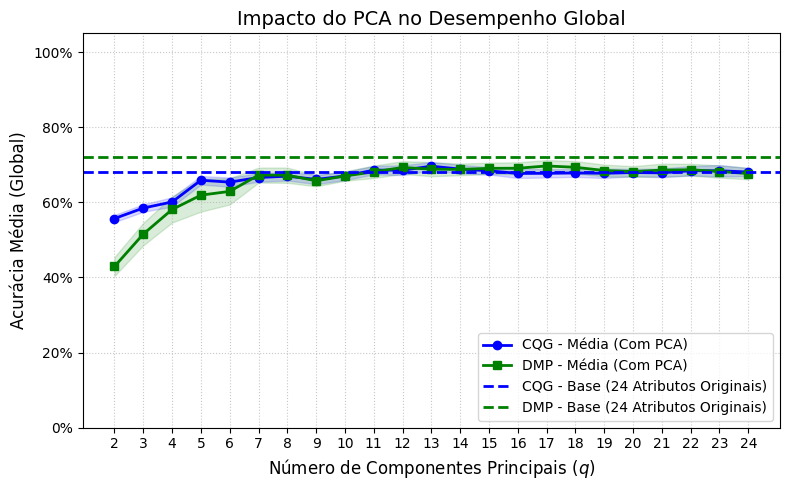

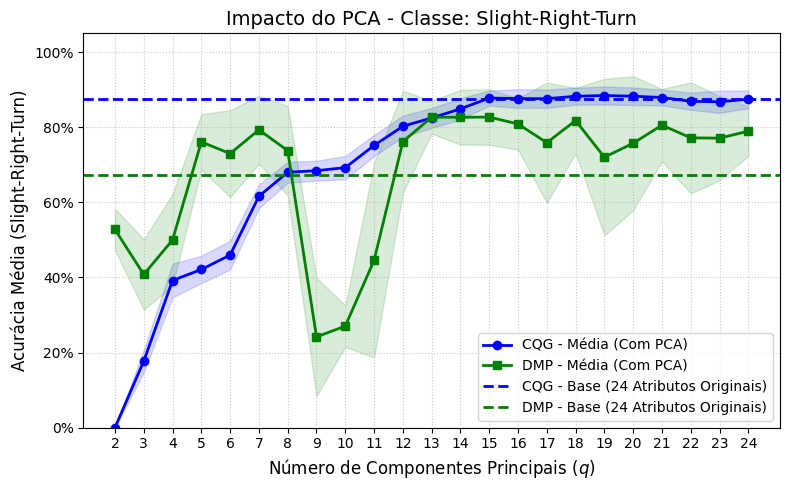

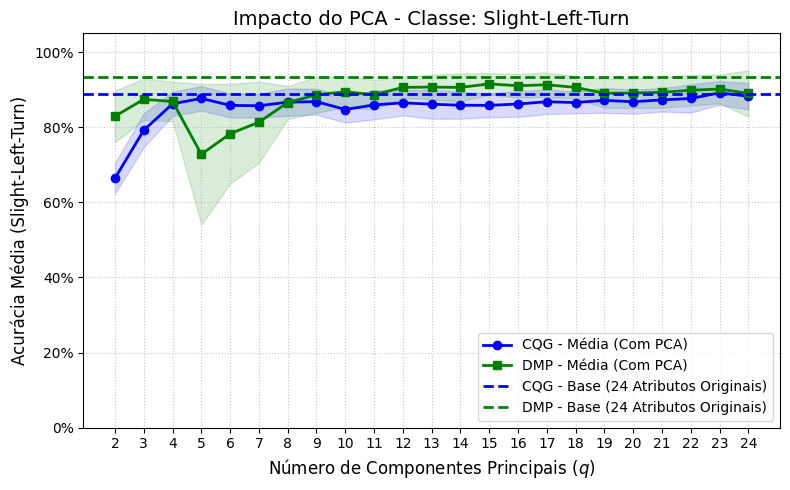

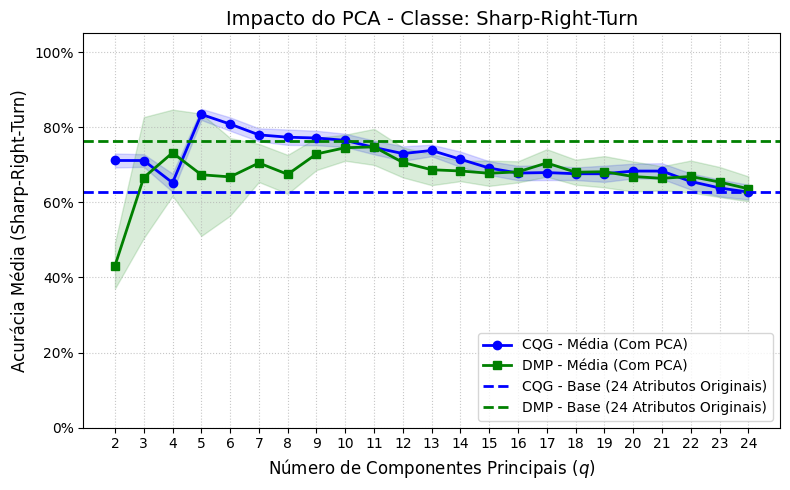

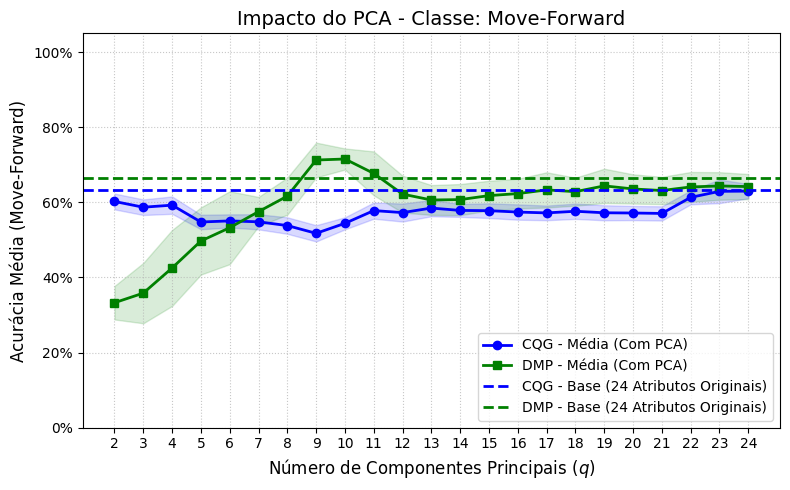

In [57]:
if __name__ == "__main__":
    # 1. Obter os dados
    # X, y, classes = carregar_dados(caminho)
    
    # 2. Rodar tudo e gerar as tabelas de Markdown (isso retorna os históricos)
    # resultados = rodar_experimentos_e_gerar_tabela_unica(X, y, classes, nr_rodadas=100)
    
    # 3. Gerar gráficos chamando a nova função:
    
    # Gráfico 1: Acurácia Global
    plotar_desempenho_pca(resultados, classe_alvo='Global')
    
    # Gráfico 2: Desempenho específico de uma classe que apresentou anomalia
    plotar_desempenho_pca(resultados, classe_alvo='Slight-Right-Turn')
    
    # Gráfico 3: Outra classe do seu conjunto de dados
    plotar_desempenho_pca(resultados, classe_alvo='Slight-Left-Turn')

    plotar_desempenho_pca(resultados, classe_alvo='Sharp-Right-Turn')

    plotar_desempenho_pca(resultados, classe_alvo='Move-Forward')

## Questão 02

Aplicar PCA ao conjunto original de 24 sensores. Pede-se:

2.1. Determinar o número de componenets (q) adequado para o problema, ou seja, que promova uma redução de dimensão dos vetores de atributo sem piorar o desempenho dos classificadores implementados. Mostre o gráfico da variância explicada VE(q).

2.2. Repetir o experimento so Subitem 1.3. para os dados transformados por PCA, preenchendo uma tabela de resultados similar. Comente os resultados obtidos.

**OBS.: A implementação das tarefas pedidas nas Questões 1 e 2 é feita simultaneamente, na verdade. Enquano um classificador é testado sem PCA, já se pode testa-lo também após aplicação de PCA. Apenas a apresentação dos resultados é que é separada em duas questões para facilitar melhoro entendimento do efeito da aplicação de PCA**

---
¹ Este classificador é construído aplicando-se o algoritmo de K-médias aos dados de cada classe em separado. Cada classe terá seu número de protótipos, sendo que estes herdam o rótulo da classe a qual pertencem. Durante o teste, funciona como classificador distância mínima ao centroide, onde deve-se encontrar o protótipo da classe mais próxima. Para mais detalhes, vide slides do assunto "Introdução à Clusterização - Métodos Particionais"

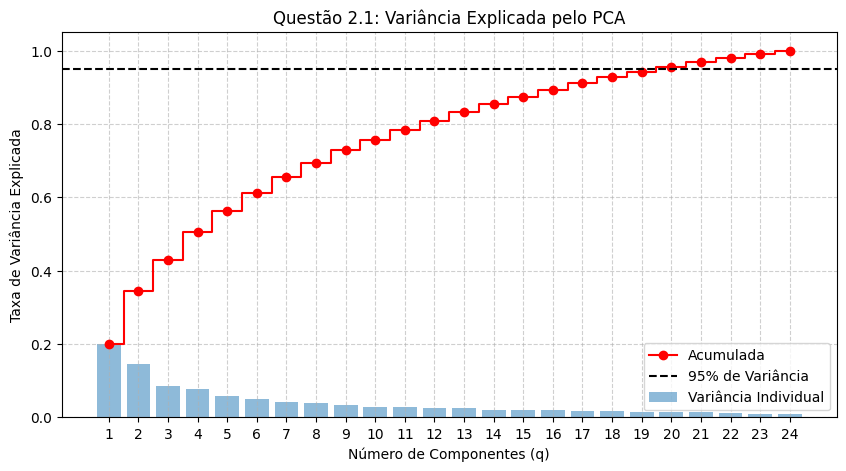

In [91]:
pca_full = PCA(n_components=None)
pca_full.fit(X)

var_ratio = pca_full.explained_variance_ratio_
var_acumulada = np.cumsum(var_ratio)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(var_ratio) + 1), var_ratio, alpha=0.5, label='Variância Individual')
plt.step(range(1, len(var_acumulada) + 1), var_acumulada, where='mid', color='red', marker='o', label='Acumulada')
plt.ylabel('Taxa de Variância Explicada')
plt.xlabel('Número de Componentes (q)')
plt.title('Questão 2.1: Variância Explicada pelo PCA')
plt.xticks(range(1, len(var_ratio) + 1))
plt.axhline(y=0.95, color='k', linestyle='--', label='95% de Variância')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()